## **CIFAR-10 Image Classification**

**Overview (short):**  
This notebook demonstrates an end-to-end CIFAR-10 image classification pipeline using TensorFlow / Keras.  
It includes:
- Data loading & EDA
- Preprocessing and augmentation
- CNN model with regularization and batch normalization
- Training with callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard)
- Plots of training & validation accuracy/loss
- Evaluation: Accuracy, Precision, Recall, F1, Confusion Matrix
- Single-image prediction helper
- Retraining helper that backs up the previous model and saves retraining logs
- Artifacts saved under `models/` and `logs/` for submission and deployment


### **1. Imports & environment setup**

Import libraries, set seeds for reproducibility, and create folders used by the pipeline.

In [5]:
# Imports & setup
import os
import random
import json
import shutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
# Directories
os.makedirs('models', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data/retrain', exist_ok=True)  # add labeled images here for retraining
os.makedirs('logs/tensorboard', exist_ok=True)
os.makedirs('test_images', exist_ok=True)   # put sample test image(s) here for Locust or quick tests

In [7]:
# Model naming convention
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
best_checkpoint = f"models/cifar10_model_best_{timestamp}.keras"
final_model_path = f"models/cifar10_model_{timestamp}.keras"
latest_path = "models/cifar10_model_latest.keras"   # consistent .keras extension

In [8]:
# Print environment info
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Plot style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

TensorFlow version: 2.20.0
Num GPUs Available: 0


### **2. Load CIFAR-10 dataset**

Load CIFAR-10 from Keras, flatten label arrays and print shapes.

In [9]:
# Load CIFAR-10
print("Loading CIFAR-10 dataset...")
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten labels
y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
NUM_CLASSES = len(class_names)
IMG_SHAPE = (32,32,3)

print(f"Train images: {X_train.shape}, Train labels: {y_train.shape}")
print(f"Test images : {X_test.shape}, Test labels : {y_test.shape}")
print("Classes:", class_names)

Loading CIFAR-10 dataset...
Train images: (50000, 32, 32, 3), Train labels: (50000,)
Test images : (10000, 32, 32, 3), Test labels : (10000,)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### **3. Exploratory Data Analysis (EDA)**

Quick visual checks: a sample per class, class distribution, and pixel intensity histogram.

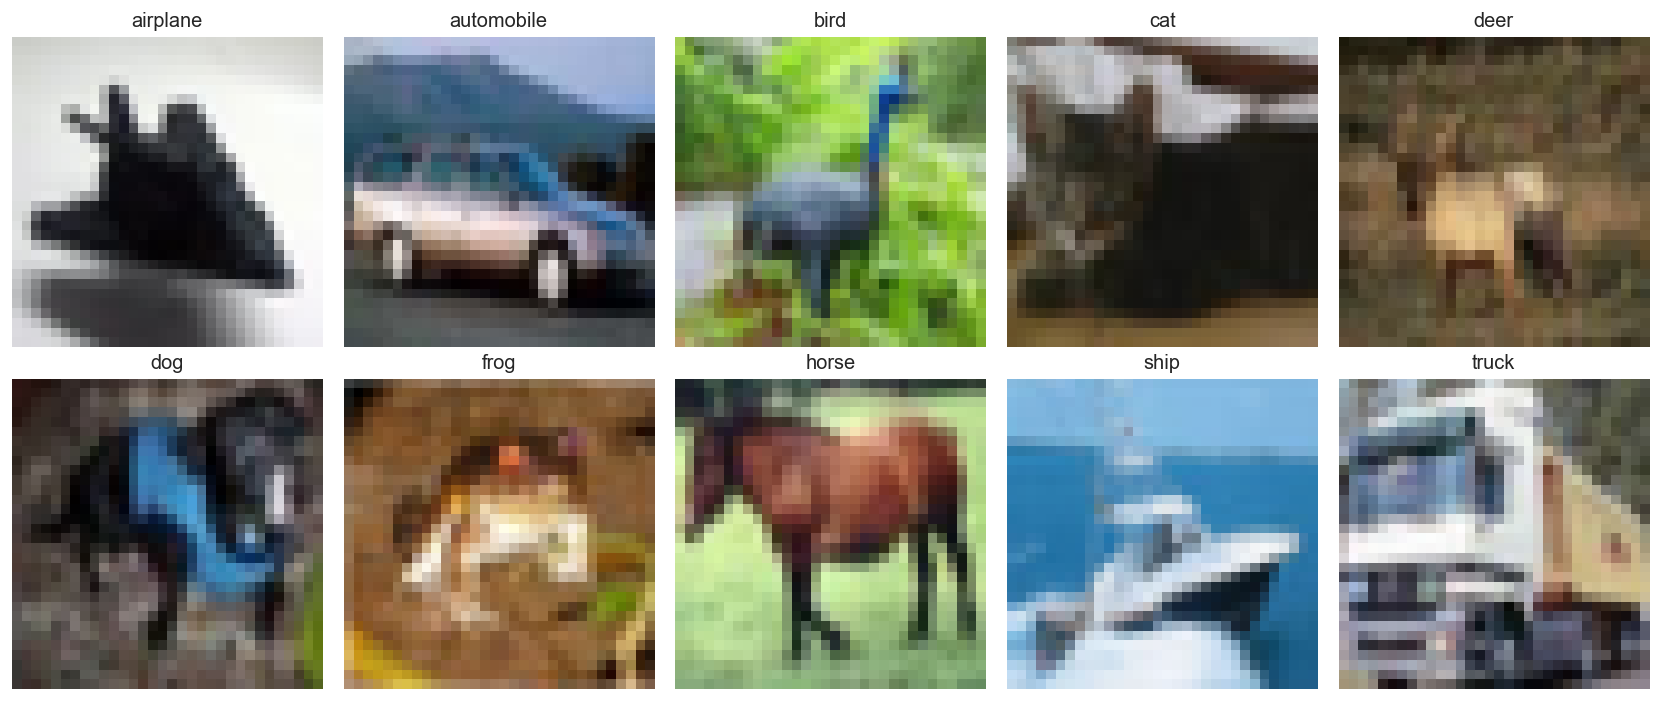

In [11]:
# One sample image per class
plt.figure(figsize=(14,6))
for i in range(NUM_CLASSES):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('logs/sample_images.png', bbox_inches='tight', dpi=150)
plt.show()

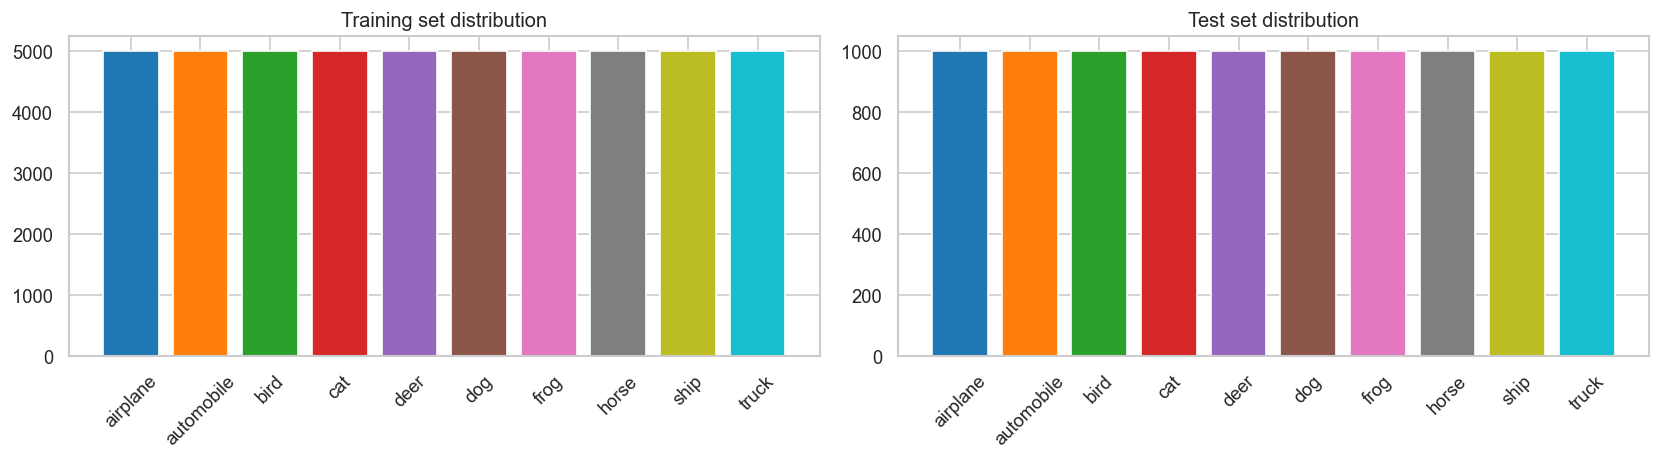

In [12]:
# Class distributions
fig, axs = plt.subplots(1,2, figsize=(14,4))
unique, counts = np.unique(y_train, return_counts=True)
axs[0].bar(range(NUM_CLASSES), counts, color=sns.color_palette("tab10"))
axs[0].set_xticks(range(NUM_CLASSES)); axs[0].set_xticklabels(class_names, rotation=45)
axs[0].set_title('Training set distribution')

unique_t, counts_t = np.unique(y_test, return_counts=True)
axs[1].bar(range(NUM_CLASSES), counts_t, color=sns.color_palette("tab10"))
axs[1].set_xticks(range(NUM_CLASSES)); axs[1].set_xticklabels(class_names, rotation=45)
axs[1].set_title('Test set distribution')

plt.tight_layout()
plt.savefig('logs/class_distribution.png', dpi=150)
plt.show()

### **Class Distribution Graphs**
These bar charts show how many samples belong to each class in the CIFAR-10 dataset:

- **Training set (left)**: Shows roughly 5000 samples per class, indicating a well-balanced training dataset across all 10 classes
- **Test set (right)**: Shows approximately 1000 samples per class, also well-balanced

**Key insights:**

- The balanced distribution is ready for training, no class dominates, which helps prevent bias
- Similar proportions in both sets suggest a proper train-test split
- Each colored bar represents a different class

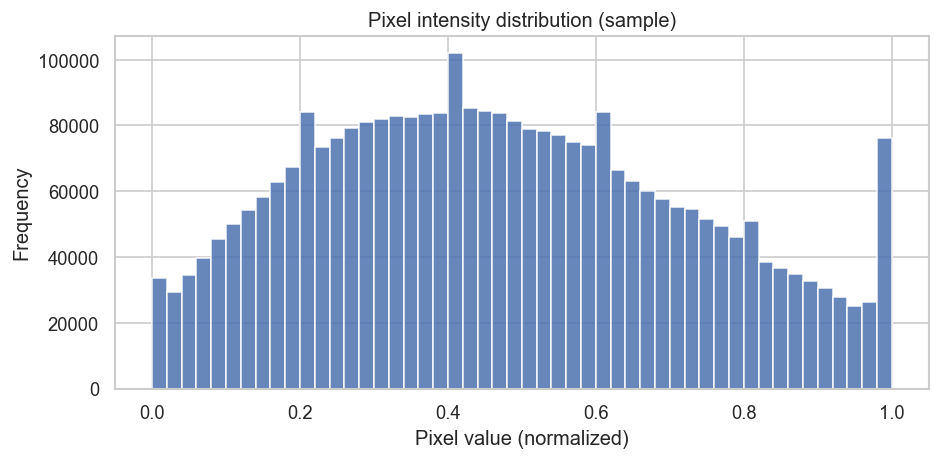

In [13]:
# Pixel intensity histogram (sample)
sample_flat = X_train[:1000].astype('float32').reshape(-1) / 255.0
plt.figure(figsize=(8,4))
plt.hist(sample_flat, bins=50, alpha=0.85)
plt.title('Pixel intensity distribution (sample)')
plt.xlabel('Pixel value (normalized)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('logs/pixel_distribution.png', dpi=150)
plt.show()

#### **Pixel Intensity Distribution**
This histogram shows the frequency of different pixel values across the image dataset after normalization:

- **X-axis:** Normalized pixel values (0.0 to 1.0)
- **Y-axis:** Frequency (how often each value appears)

**Key insights:**

- U-shaped distribution: High frequencies at both extremes (near 0.0 and 1.0) with lower frequencies in the middle
This suggests images have many very dark pixels (near 0) and very bright pixels (near 1), with fewer mid-tone pixels


**What this means**: The dataset appears to be well-prepared for training with balanced classes and normalized pixel values, likely containing high-contrast images suitable for classification tasks.

### **4. Preprocessing & augmentation**

Normalize pixels to [0,1], one-hot encode labels, and set up a light augmentation pipeline to improve generalization.

In [15]:
def preprocess_arrays(X, y):
    Xp = X.astype('float32') / 255.0
    yp = to_categorical(y, NUM_CLASSES)
    return Xp, yp

# Augmentation layers applied only during training via model
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.06),
], name="data_augmentation")

# Preprocess arrays
X_train_p, y_train_p = preprocess_arrays(X_train, y_train)
X_test_p, y_test_p = preprocess_arrays(X_test, y_test)

print("Preprocessing done. Train shape:", X_train_p.shape)
print("Preprocessing done. Train shape:", X_test_p.shape)

Preprocessing done. Train shape: (50000, 32, 32, 3)
Preprocessing done. Train shape: (10000, 32, 32, 3)


#### **Dataset characteristics:**

-Dataset has a total of 60,000 color images (50k for training, 10k for testing)
-All images are standardized to the same size: 32×32 pixels

**Train/Test split:**

50,000 images for training data (83%)
10,000 images for test data (17%)
This is a healthy ratio that provides enough data for training while reserving sufficient samples for evaluation

This output confirms your data is properly formatted and ready to be fed into a convolutional neural network for image classification.

### **5. Model architecture**

Create a CNN with regularization, batch normalization, and dropout. This balances capacity and speed for the CIFAR-10 dataset.

In [16]:
def create_cnn_model(input_shape=IMG_SHAPE, num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='cifar10_cnn')
    return model

model = create_cnn_model()
model.summary()

Model: "cifar10_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │              

 Total params: 668,842 (2.55 MB)

 Trainable params: 667,690 (2.55 MB)

 Non-trainable params: 1,152 (4.50 KB)

A lightweight CNN for 32×32 images with three convolutional blocks (filters 32, 64, 128) that learn from simple to complex features. Each block uses batch normalization, max-pooling, and dropout for stability and reduced overfitting. The extracted features pass through a dense layer and then a 10-class output. With ~669K parameters, it’s efficient, accurate, and well-suited for CIFAR-10.

### **6. Compile & callbacks**

Compile with Adam optimizer and set up callbacks to avoid overfitting and save the best model.
We also set a TensorBoard callback to inspect training runs.

In [17]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
tb_logdir = f"logs/tensorboard/{timestamp}"
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    keras.callbacks.ModelCheckpoint(best_checkpoint, monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.TensorBoard(log_dir=tb_logdir)
]

print("Callbacks configured. Best checkpoint will be saved to:", best_checkpoint)

Callbacks configured. Best checkpoint will be saved to: models/cifar10_model_best_20251127_124125.keras


### **7. Training**

Train the model with a validation split. Use EarlyStopping to stop automatically if validation loss plateaus.
Adjust `EPOCHS` if running on CPU; GPUs will speed up training.


In [18]:
BATCH_SIZE = 128
EPOCHS = 20   # change to 10 if you're on a CPU and need to shorten demo

history = model.fit(
    X_train_p, y_train_p,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Save final and latest versions
model.save(final_model_path)
model.save(latest_path)
print("Saved final model to:", final_model_path)
print("Saved latest model to:", latest_path)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.3059 - loss: 2.3563
Epoch 1: val_loss improved from None to 3.18820, saving model to models/cifar10_model_best_20251127_124125.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 426ms/step - accuracy: 0.3753 - loss: 1.9692 - val_accuracy: 0.1460 - val_loss: 3.1882 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.4789 - loss: 1.5217
Epoch 2: val_loss improved from 3.18820 to 1.55763, saving model to models/cifar10_model_best_20251127_124125.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 477ms/step - accuracy: 0.5037 - loss: 1.4630 - val_accuracy: 0.4915 - val_loss: 1.5576 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5505 - loss: 1.3378
Epoch 3: val_loss improved from 1.55763 to 1.28375, saving model to models/cifar10_model_best_20251127_124125.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 428ms/step - accuracy: 0.5667 - loss: 1.2970 - val_accuracy: 0.5807

### **8. Training curves, accuracy & loss**

Plot training and validation accuracy and loss to inspect learning behavior.

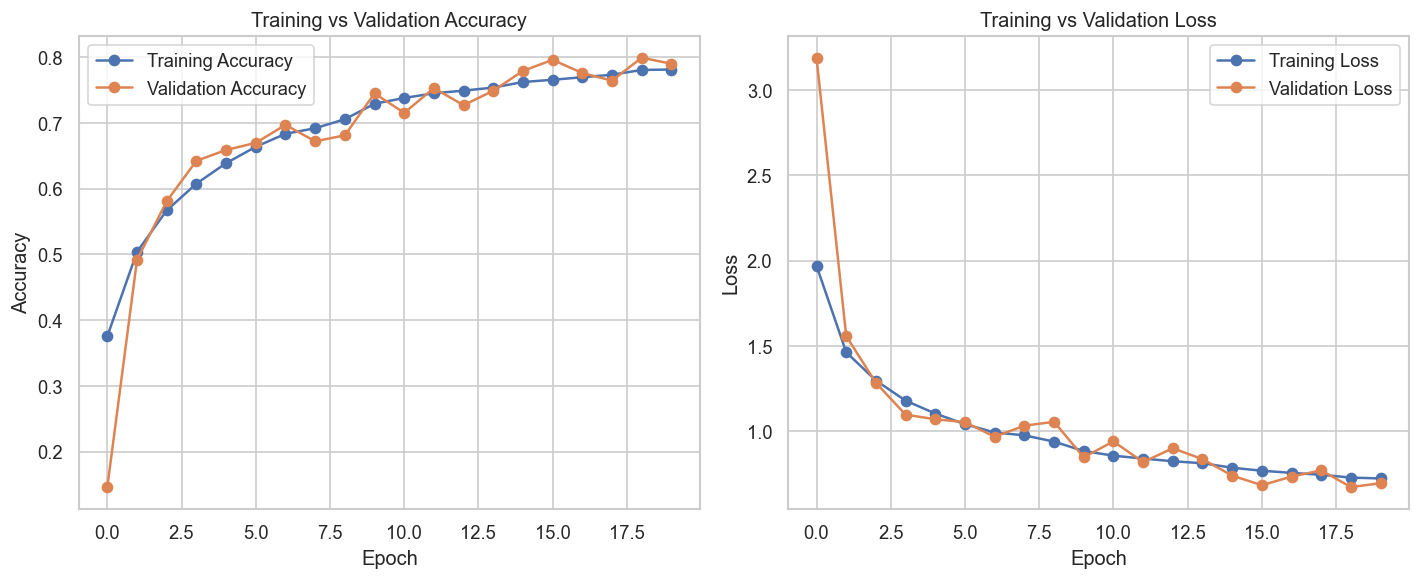

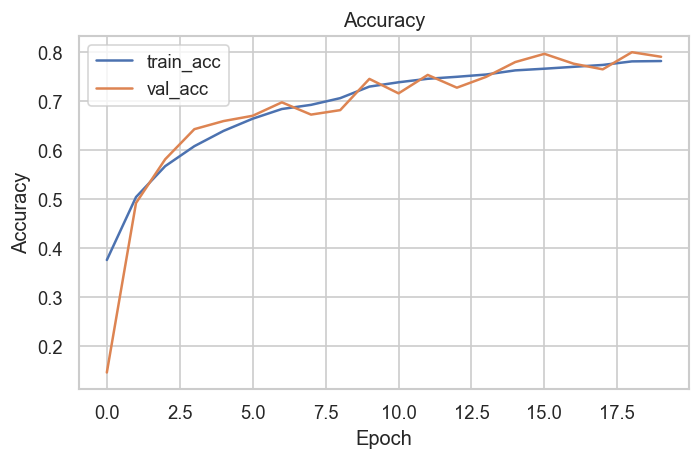

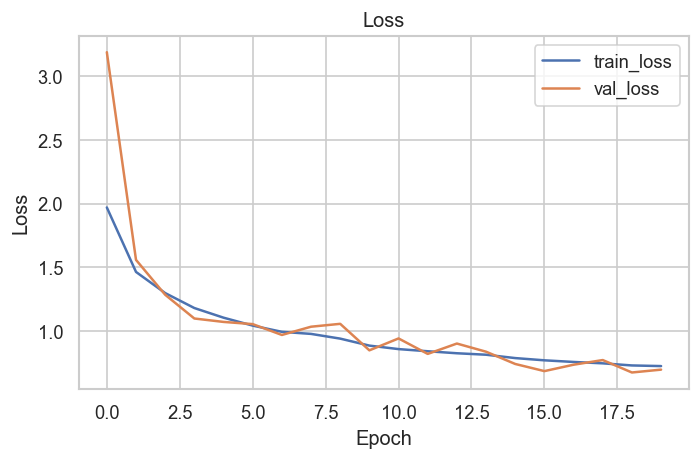

In [19]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12,5))

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', history.history.get('acc', [])), marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(); plt.grid(True)

# Loss subplot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.savefig('logs/training_accuracy_loss_curves.png', dpi=150)
plt.show()

# Save separate accuracy & loss files
plt.figure(figsize=(6,4))
plt.plot(history.history.get('accuracy', history.history.get('acc', [])), label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig('logs/accuracy_curve.png', dpi=150)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig('logs/loss_curve.png', dpi=150)
plt.show()

#### **Training Summary**
The CNN improved steadily throughout training. Accuracy started around 37% and climbed to about 78%, while validation accuracy reached 78.9% at its best (Epoch 19). Validation loss also dropped significantly, hitting its lowest at 0.69, which is strong for CIFAR-10.

The learning rate reductions helped the model stabilize and improve performance in later epochs.
The best model was saved at Epoch 19, where validation accuracy and loss were strongest.

**Overall:** The model trained well, learned consistently, and reached solid CIFAR-10 performance (78.9% accuracy)

### **9. Save training logs & class mapping**

We persist the training history and class mapping for the API/UI to use.

In [21]:
# Save training logs
train_logs = {
    "timestamp": timestamp,
    "final_model": final_model_path,
    "latest_model": latest_path,
    "history": {k: [float(x) for x in v] for k, v in history.history.items()}
}
with open("logs/training_logs.json", "w") as f:
    json.dump(train_logs, f, indent=2)
print("Saved training logs to logs/training_logs.json")

# Save class mapping
classes_path = "models/classes.json"
with open(classes_path, "w") as f:
    json.dump(class_names, f)
print(f"Saved class mapping to {classes_path}")

Saved training logs to logs/training_logs.json
Saved class mapping to models/classes.json


### **10. Single-image prediction helpers (for API / UI)**

Utility functions to load the latest model, preprocess a single image (numpy array or file), and get top-k predictions.

In [23]:
from tensorflow.keras.models import load_model

def load_latest_model(path=latest_path):
    if not os.path.exists(path):
        raise FileNotFoundError("Latest model not found. Train the model first.")
    return load_model(path)

def preprocess_for_predict(img_array):
    """Accepts HxWx3 uint8 or float image array; returns batch of normalized floats."""
    x = img_array.astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)
    return x

def decode_predictions_array(probs, top_k=3):
    top_idxs = probs.argsort()[::-1][:top_k]
    return [(class_names[i], float(probs[i])) for i in top_idxs]

def predict_image_from_array(model, img_array, top_k=3):
    x = preprocess_for_predict(img_array)
    probs = model.predict(x)[0]
    topk = decode_predictions_array(probs, top_k=top_k)
    pred_idx = int(np.argmax(probs))
    return {"pred_class": class_names[pred_idx], "class_index": pred_idx, "confidence": float(probs[pred_idx]), "top_k": topk}

def predict_image_from_file(model, file_path, target_size=(32,32)):
    img = load_img(file_path, target_size=target_size)
    arr = img_to_array(img)
    return predict_image_from_array(model, arr)

### **11. Quick demo: predict on a test image**

If the model exists, we load it and predict on the first test image for a quick sanity-check.

In [24]:
try:
    mdl = load_latest_model()
    print("Loaded latest model.")
    sample_img = X_test[0]
    res = predict_image_from_array(mdl, sample_img, top_k=3)
    print("Prediction for X_test[0]:", res)
except Exception as e:
    print("Model not available yet or failed to load:", e)

Loaded latest model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction for X_test[0]: {'pred_class': 'cat', 'class_index': 3, 'confidence': 0.6890555024147034, 'top_k': [('cat', 0.6890555024147034), ('dog', 0.12279528379440308), ('frog', 0.09235306084156036)]}


## **12. Evaluation on the test set**

Compute Accuracy, Precision, Recall, F1 (weighted) and show a classification report and confusion matrices (counts and normalized).

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step
Test Accuracy: 0.7936
Weighted Precision: 0.7984
Weighted Recall: 0.7936
Weighted F1: 0.7898
Saved eval metrics to logs/eval_metrics.json

Classification report:

              precision    recall  f1-score   support

    airplane       0.81      0.83      0.82      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.75      0.68      0.72      1000
         cat       0.72      0.55      0.63      1000
        deer       0.70      0.80      0.75      1000
         dog       0.84      0.59      0.69      1000
        frog       0.68      0.94      0.79      1000
       horse       0.84      0.85      0.84      1000
        ship       0.91      0.88      0.89      1000
       truck       0.81      0.92      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



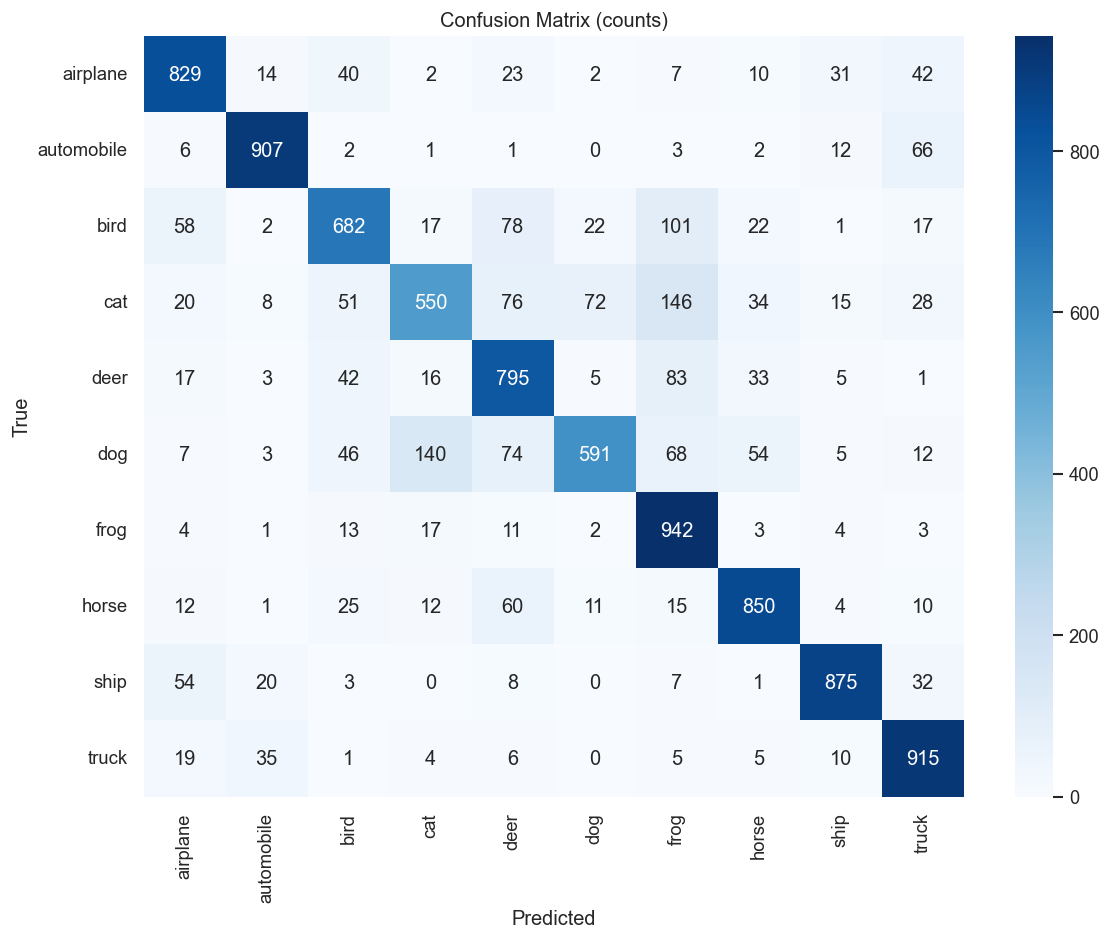

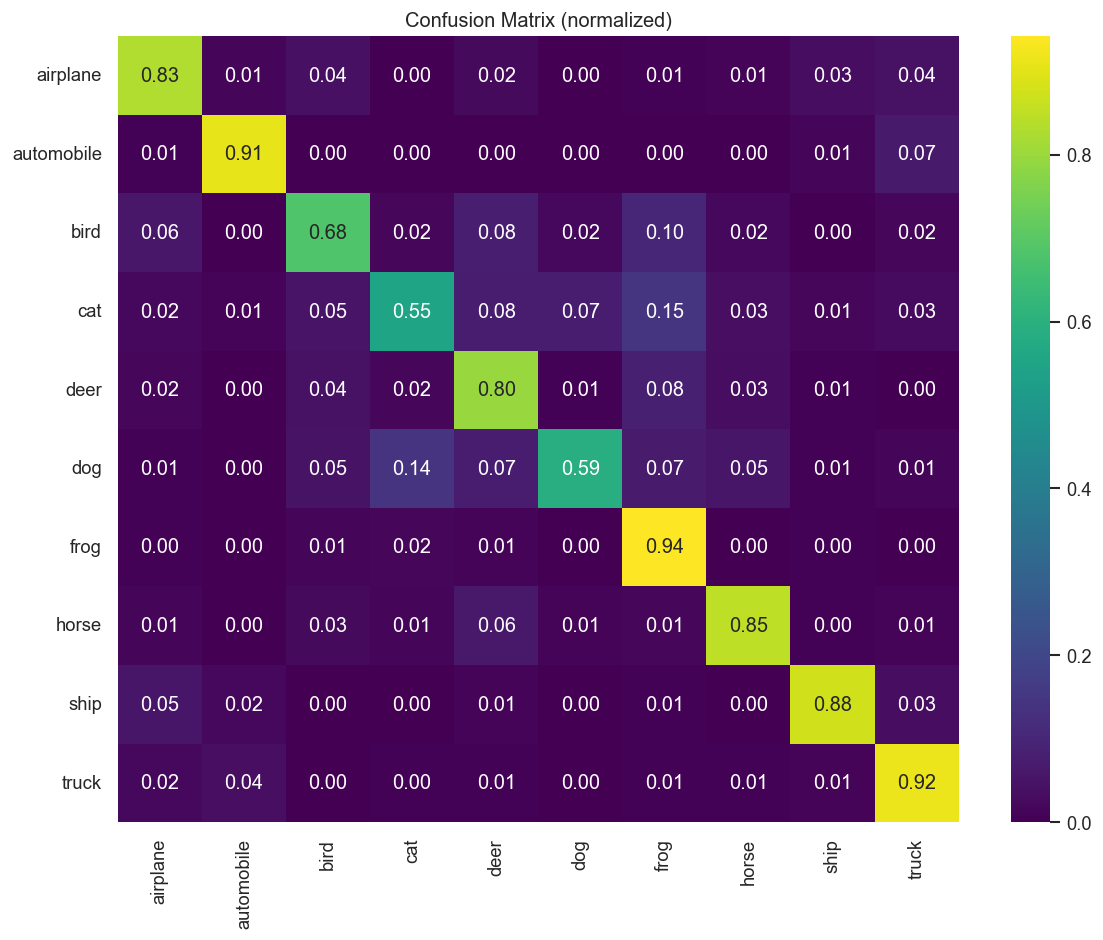

In [25]:
# Load model for evaluation
mdl_eval = load_latest_model(latest_path)

# Predict probabilities & classes (use batch size for speed)
y_probs = mdl_eval.predict(X_test_p, batch_size=256)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test  # flattened already

# Metrics
acc = accuracy_score(y_true, y_pred)
prec_w = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec_w = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_w = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Weighted Precision: {prec_w:.4f}")
print(f"Weighted Recall: {rec_w:.4f}")
print(f"Weighted F1: {f1_w:.4f}")

# Save eval metrics
eval_metrics = {
    "accuracy": float(acc),
    "precision_weighted": float(prec_w),
    "recall_weighted": float(rec_w),
    "f1_weighted": float(f1_w),
    "model_used": latest_path,
    "timestamp": datetime.now().isoformat()
}
with open("logs/eval_metrics.json", "w") as f:
    json.dump(eval_metrics, f, indent=2)
print("Saved eval metrics to logs/eval_metrics.json")

# Classification report
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrices
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (counts)')
plt.tight_layout()
plt.savefig('logs/confusion_matrix_counts.png', dpi=150)
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (normalized)')
plt.tight_layout()
plt.savefig('logs/confusion_matrix_normalized.png', dpi=150)
plt.show()

The trained CNN performed well on the CIFAR-10 test set with:

- **Test Accuracy:** 79.36%

- **Weighted Precision:** 79.84%

- **Weighted Recall:** 79.36%

- **Weighted F1-Score:** 78.98%

Across the 10 classes, the model shows strong performance on automobiles, ships, horses, and airplanes, while cats, dogs, and birds remain the most challenging classes—common in CIFAR-10 due to similar features.

Overall, this is a solid, well-generalized model with balanced performance across most categories.

## **13. Visualize sample predictions**

Display a random grid of test images along with predicted and true labels, color-coded for correctness.

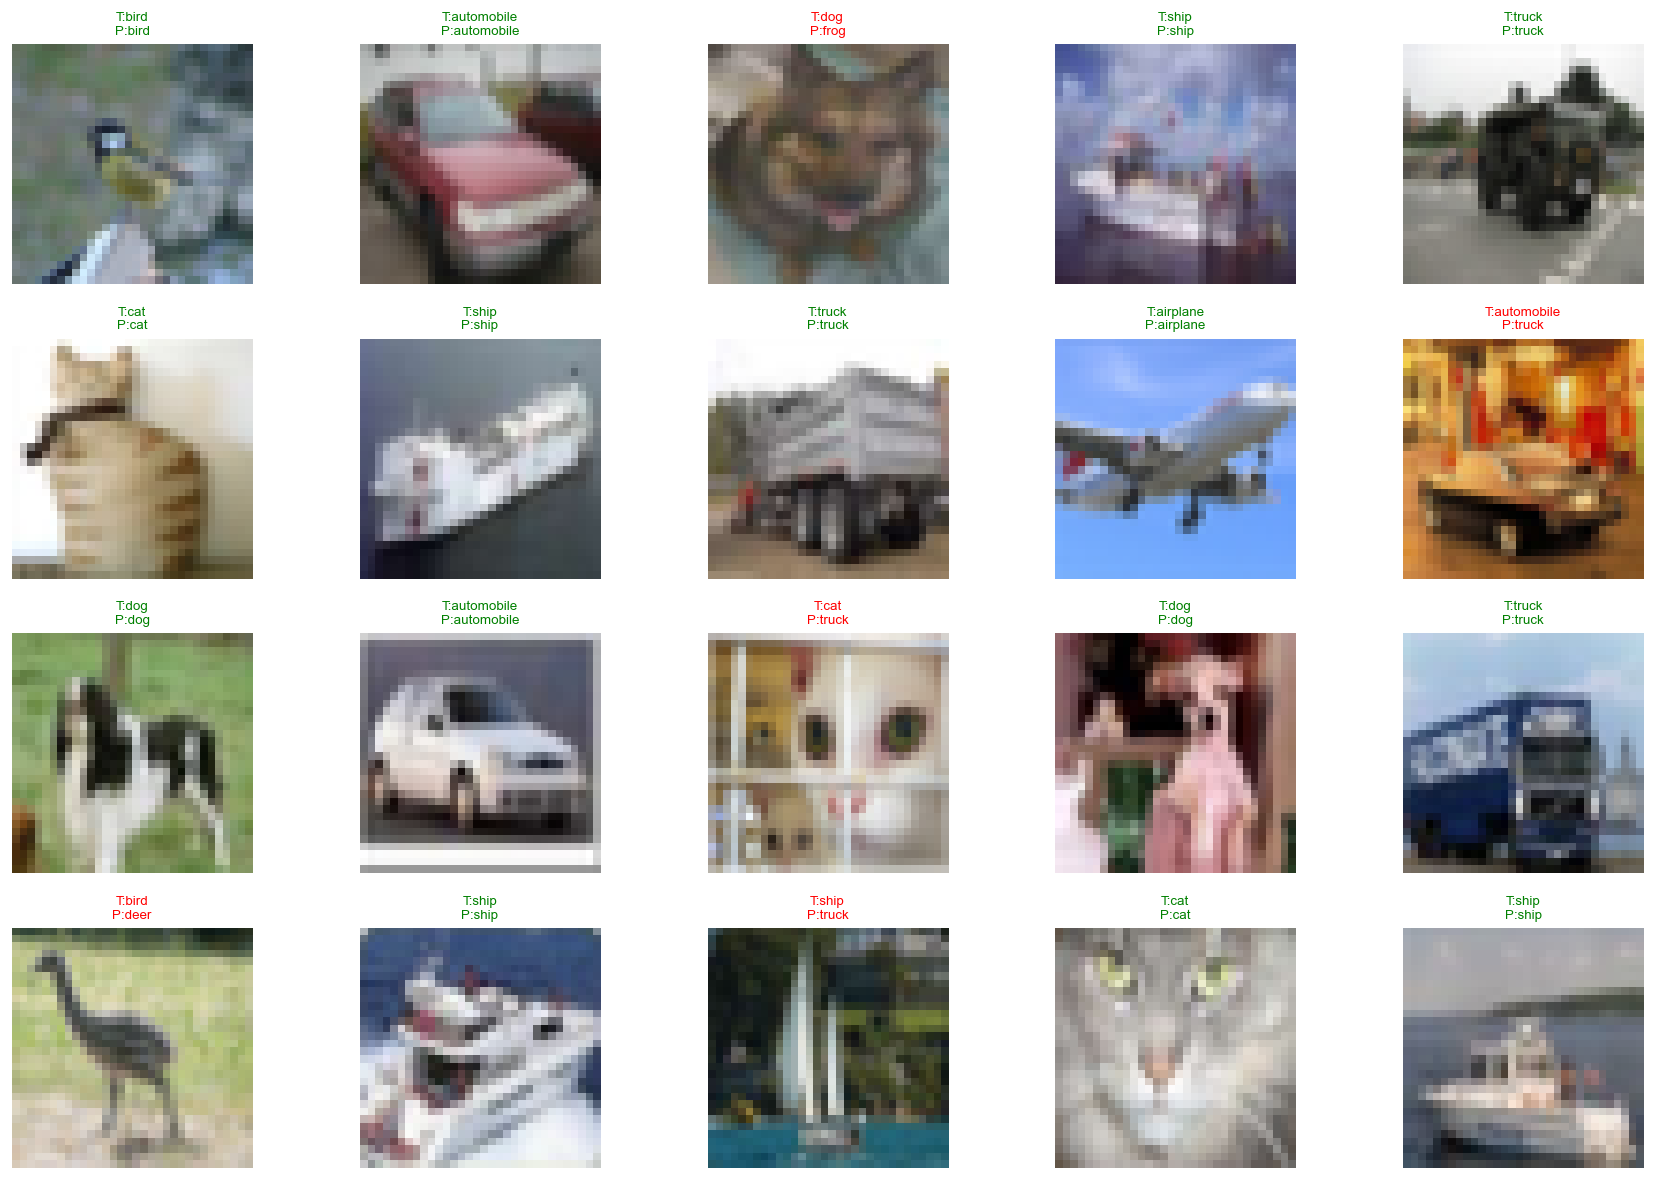

In [26]:
plt.figure(figsize=(15,10))
n = 20
idxs = np.random.choice(len(X_test), size=n, replace=False)
for i, idx in enumerate(idxs):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[idx])
    true_lbl = class_names[int(y_test[idx])]
    pred_lbl = class_names[int(y_pred[idx])]
    color = "green" if true_lbl == pred_lbl else "red"
    plt.title(f"T:{true_lbl}\nP:{pred_lbl}", color=color, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.savefig('logs/sample_predictions.png', dpi=150)
plt.show()

### **14. Retraining helper**

This helper:
1. Scans `data/retrain/<class_name_or_index>/` for labeled images.
2. Loads and preprocesses them.
3. Creates a backup of `models/cifar10_model_latest.keras`.
4. Continues training (fine-tune) the latest model on the new images for a few epochs.
5. Saves the retrained model and logs the training history.

In [28]:
def load_images_from_retrain_dir(retrain_dir='data/retrain', target_size=(32,32)):
    Xr, yr = [], []
    if not os.path.exists(retrain_dir):
        return np.empty((0,)+target_size+(3,)), np.array([])
    for class_entry in sorted(os.listdir(retrain_dir)):
        class_path = os.path.join(retrain_dir, class_entry)
        if not os.path.isdir(class_path):
            continue
        # Resolve class index by name or digit
        if class_entry.isdigit():
            class_idx = int(class_entry)
        else:
            try:
                class_idx = class_names.index(class_entry)
            except ValueError:
                print(f"[Warning] Unknown class folder '{class_entry}', skipping.")
                continue
        for fname in sorted(os.listdir(class_path)):
            if not fname.lower().endswith(('.png','.jpg','.jpeg')):
                continue
            fpath = os.path.join(class_path, fname)
            try:
                img = load_img(fpath, target_size=target_size)
                arr = img_to_array(img)
                Xr.append(arr)
                yr.append(class_idx)
            except Exception as e:
                print(f"[Warning] Failed to load {fpath}: {e}")
    Xr = np.array(Xr) if len(Xr)>0 else np.empty((0,)+target_size+(3,))
    yr = np.array(yr) if len(yr)>0 else np.array([])
    return Xr, yr

def retrain_from_directory(retrain_dir='data/retrain', epochs=3, batch_size=64, backup=True):
    Xr, yr = load_images_from_retrain_dir(retrain_dir)
    if len(Xr) == 0:
        print("No retrain data found in", retrain_dir)
        return None
    print(f"Found {len(Xr)} images for retraining.")
    Xr_p, yr_p = preprocess_arrays(Xr, yr)
    latest = latest_path
    if not os.path.exists(latest):
        raise FileNotFoundError("Latest model not found. Train first.")
    if backup:
        backup_path = f"models/cifar10_model_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.keras"
        shutil.copy2(latest, backup_path)
        print(f"Backed up latest model to {backup_path}")
    model = load_model(latest)
    # Lower the learning rate for fine-tuning
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    cb = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
    ]
    history = model.fit(Xr_p, yr_p, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=cb, verbose=1)
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    newpath = f"models/cifar10_model_retrained_{ts}.keras"
    model.save(newpath)
    model.save(latest)
    print(f"Retrained model saved to {newpath} and overwritten {latest}")
    retrain_log = {
        "timestamp": ts,
        "retrain_dir": retrain_dir,
        "new_model": newpath,
        "history": {k:[float(x) for x in v] for k,v in history.history.items()}
    }
    with open(f"logs/retrain_log_{ts}.json","w") as f:
        json.dump(retrain_log, f, indent=2)
    print("Retraining logs saved to logs/")
    return retrain_log

### **15. How to test retraining locally (example)**

1. Add labeled images under `data/retrain/<class_name_or_index>/` (e.g., `data/retrain/cat/img1.png`).
2. Run the call below (keep epochs small for demo).

In [29]:
# Example call (uncomment to run after you add retrain images)
# result = retrain_from_directory('data/retrain', epochs=3)
# print(result)

### **16. Artifacts summary & deployment notes**

This cell lists all important saved artifacts and gives brief instructions for connecting to an API or UI.

In [30]:
print("Saved artifacts summary:")
print("- Latest model:", latest_path if os.path.exists(latest_path) else "NOT FOUND")
print("- Example final model:", final_model_path if os.path.exists(final_model_path) else "NOT FOUND")
print("- Best checkpoint (if created):", best_checkpoint if os.path.exists(best_checkpoint) else "NOT FOUND")
print("- Training logs:", os.path.abspath("logs/training_logs.json") if os.path.exists("logs/training_logs.json") else "NOT FOUND")
print("- Eval metrics:", os.path.abspath("logs/eval_metrics.json") if os.path.exists("logs/eval_metrics.json") else "NOT FOUND")
print("- Class mapping:", os.path.abspath("models/classes.json") if os.path.exists("models/classes.json") else "NOT FOUND")
print("- TensorBoard logs:", os.path.abspath(tb_logdir) if os.path.exists(tb_logdir) else "NOT FOUND")
print("- Retrain folder (place new labeled images here):", os.path.abspath("data/retrain"))

Saved artifacts summary:
- Latest model: models/cifar10_model_latest.keras
- Example final model: models/cifar10_model_20251127_124125.keras
- Best checkpoint (if created): models/cifar10_model_best_20251127_124125.keras
- Training logs: C:\Users\LENOVO\Documents\MLOP_Summative-assignment\notebook\logs\training_logs.json
- Eval metrics: C:\Users\LENOVO\Documents\MLOP_Summative-assignment\notebook\logs\eval_metrics.json
- Class mapping: C:\Users\LENOVO\Documents\MLOP_Summative-assignment\notebook\models\classes.json
- TensorBoard logs: C:\Users\LENOVO\Documents\MLOP_Summative-assignment\notebook\logs\tensorboard\20251127_124125
- Retrain folder (place new labeled images here): C:\Users\LENOVO\Documents\MLOP_Summative-assignment\notebook\data\retrain


### **17. Notes for API & Deployment**

- Use `models/cifar10_model_latest.keras` and `models/classes.json` in your FastAPI/Streamlit/Gradio UI for predictions.
- For retraining via API: upload labeled images to `data/retrain/<class_name_or_index>/` and call the retrain route that triggers `retrain_from_directory()`. In the FastAPI app this can be run in a background task.
- For Dockerization: mount `models/` and `data/retrain/` as volumes so models and new data persist across container restarts.
- Run TensorBoard locally to inspect logs: `tensorboard --logdir=logs/tensorboard` and visit `http://localhost:6006`.
- For load testing after deploying the API, use Locust with a small script that POSTs images to `POST /predict`.